# COMP90084 Workshop Week 7
In this week's workshop, we'll program the algorithms we encountered during the lectures last week.

In [7]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit as qk
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector
%matplotlib inline
# shots simulation
backend_sim = Aer.get_backend('qasm_simulator')
# statevector
backend_sv = Aer.get_backend('statevector_simulator')


Q1

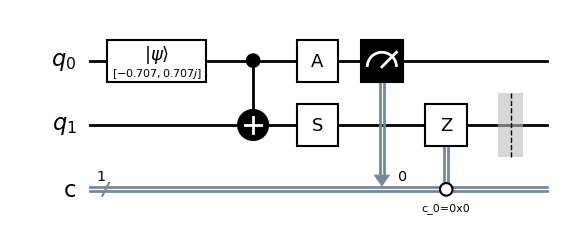

State observed q1:
 [[0.5       +0.j         0.35355339-0.35355339j]
 [0.35355339+0.35355339j 0.5       +0.j        ]]
State expected q1:
 [[0.5       +0.j         0.35355339+0.35355339j]
 [0.35355339-0.35355339j 0.5       +0.j        ]]


In [76]:
from math import sqrt
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.states import Statevector
import math
alpha = complex(0.24506488, 0.9633)
beta = complex(0.0046248, 0.10943)



def Q1(a, b):
    qc = QuantumCircuit(2, 1)
    qc.initialize([a,b], 0)
    qc.cx(0,1)
    qc.s(1)
    sqrt_2_half = math.sqrt(2)/2
    recp_sqrt_2 = 1/math.sqrt(2)
    # qc.barrier()
    cx = Operator([
        [recp_sqrt_2, -recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
        [recp_sqrt_2, recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
    ])
    qc.unitary(cx, 0, label='A')
    qc.measure(0,0)
    qc.z(1).c_if(0, 0)
    qc.snapshot(label="Bob_State", qubits=[1])
    
    
    
    return qc

# qc = Q1(sqrt(2)/2, sqrt(2)/2)
# a = 0
# b = 1
a=-1/np.sqrt(2)
b=1j/np.sqrt(2)
qc = Q1(a, b)
display(qc.draw('mpl', style = "bw"))

job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()


state = partial_trace(result.get_statevector(), [0]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
print("State observed q1:\n",np.real_if_close(state.data))

sqrt_2_half = math.sqrt(2)/2
T = np.array([
    [1, 0], 
    [0, complex(sqrt_2_half, sqrt_2_half)]])

T_psi = T.dot([a, b])
print("State expected q1:\n",np.real_if_close(DensityMatrix(Statevector(T_psi)).data))


{'01': 1022, '00': 1026}
Classical information sent by Alice: dict_keys(['01', '00'])
State recieved by Bob:
 [[1.]]


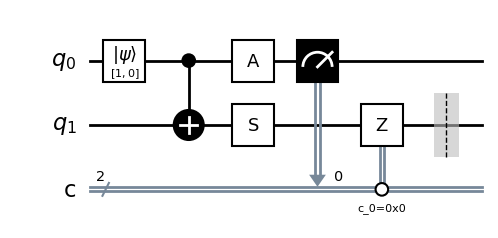

In [44]:

job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()
counts = result.get_counts(qc)
print(counts)
print("Classical information sent by Alice:", counts.keys())
bob_state = partial_trace(result.get_statevector(), [0,1]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
print("State recieved by Bob:\n",np.real_if_close(bob_state.data))
qc.draw('mpl',style="bw", scale = 1)

Q1.2

Q1.2.a

This problem can be solved in 1 query with the Deutsh Jozsa Algorithmn.
The algorithmn works by feeding in qubits in a superposition into the function, and conditionally apply it second quibit also in the superposition state.
This hamard n gate acts to sum all this qbits
After passing through the function, they are summation of (-1)^f(xi)
Apply another Hammard gate but only inspect the |0> state, which is dependent upon f(x).
The sum is either constant for -1 or +1, else if balance it is 0.


-----------------------------------------------------


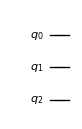

{'00': 2048}
constant


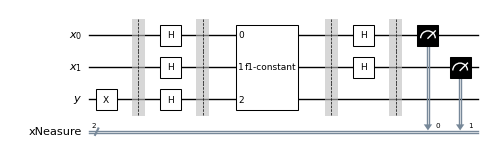

-----------------------------------------------------


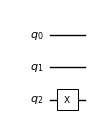

{'00': 2048}
constant


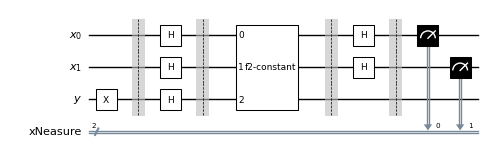

-----------------------------------------------------


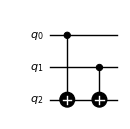

{'11': 2048}
balanced


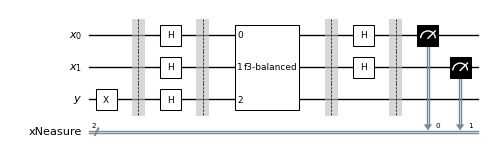

-----------------------------------------------------


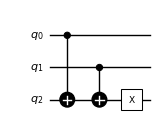

{'11': 2048}
balanced


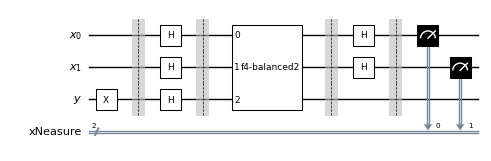

In [106]:
def f1():
    qc = QuantumCircuit(3, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(3, name="f2-constant")
    qc.x(2)
    return qc


def f3():
    qc = QuantumCircuit(3, name="f3-balanced")
    qc.cx(0, 2)
    qc.cx(1, 2)
    return qc

def f4():
    qc = QuantumCircuit(3, name="f4-balanced2")
    qc.cx(0, 2)
    qc.cx(1, 2)
    qc.x(2)
    return qc

# define the Deutsch-Jozsa function
def deutsch_josza(function=None, num_qubits = 2):
    x = QuantumRegister(num_qubits-1, "x")
    y = QuantumRegister(1, "y")
    cr = ClassicalRegister(num_qubits-1, "xNeasure")

    qc = QuantumCircuit(x, y, cr)
    # X gate on the function output qubit
    qc.x(y)
    qc.barrier()
    # H gate everywhere
    qc.h([*x, *y])
    qc.barrier()
    # append the function
    if function is None:
        f = Gate(name='Uf', num_qubits=num_qubits, params=[])
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    else:
        f = function.to_instruction()
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    qc.h(x)
    qc.barrier()
    qc.measure(x, cr)
    return qc

def print_is_balanced_or_constant(Uf, num_qubits):
    print("-----------------------------------------------------")
    display(Uf.draw('mpl',style="bw", scale = 0.5))
    dj_1_qubit = deutsch_josza(Uf, num_qubits)
    job_dj_1_qubit = backend_sim.run(transpile(dj_1_qubit, backend_sim), shots=2048)
    result_dj_1_qubit = job_dj_1_qubit.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(dj_1_qubit)
    print(counts_dj_1_qubit)

    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key
    
    #if only zeros, then it is constant, else balanaced
    if(max_key.find("1") == -1):
        print("constant")
    else:
        print("balanced")
    
    display(dj_1_qubit.draw('mpl',style="bw", scale = 0.5))
    



print_is_balanced_or_constant(f1(), 3)

print_is_balanced_or_constant(f2(), 3)

print_is_balanced_or_constant(f3(), 3)

print_is_balanced_or_constant(f4(), 3)

Q1.2.2

In [107]:
def f1():
    qc = QuantumCircuit(4, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(4, name="f2-constant")
    qc.x(3)
    return qc


def f3():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    return qc

def f4():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.x(3)
    return qc

def calc_answer(circuit, i, j, k, showExample):
    num_qubits = 4

    num_c_bits = 1
    qr = QuantumRegister(num_qubits, "x and y")
    if(showExample):
        cr1 = ClassicalRegister(num_qubits, "state0")
        cr2 = ClassicalRegister(num_qubits, "state1")
        cr3 = ClassicalRegister(num_qubits, "state3")

        qc = QuantumCircuit(qr, cr1, cr2, cr3)

        qc.measure(qr, cr1)
        qc.barrier()

    else:
        cr3 = ClassicalRegister(1, "out")
        qc = QuantumCircuit(qr, cr3)

    if(i == 1):
        qc.x(0)
    if(j == 1):
        qc.x(1)
    if(k == 1):
        qc.x(2)

    qc.barrier()
    
    
    if(showExample):
        qc.measure(qr, cr2)
        qc.barrier()

    f = circuit.to_instruction()
    qc.append(f, list(range(num_qubits)))
    qc.barrier()

    if(showExample):
        qc.measure(qr, cr3)
    else:
        qc.measure(3, 0)


    job = backend_sim.run(transpile(qc, backend_sim), shots=2048)
    result_dj_1_qubit = job.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(qc)
    if(showExample):
        display(qc.draw('mpl',style="bw", scale = 0.5))
    
    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key

    max_key = max_key[::-1]

    if(showExample):
        splits = max_key.split(" ")
        return {"state1: " : splits[0], "state2: " : splits[1], "state3: " : splits[2]}
    else:
        return max_key

def proof_of_work(circuit):
    
    results = {}

    for i in range(2):
        for j in range(2):
            for k in range(2):
                results[str(i)+str(j)+str(k)] = calc_answer(circuit, i, j, k, False)

    print(circuit.name, end =": ")
    print(results)






In [108]:
proof_of_work(f1())
proof_of_work(f2())
proof_of_work(f3())
proof_of_work(f4())

f1-constant: {'000': '0', '001': '0', '010': '0', '011': '0', '100': '0', '101': '0', '110': '0', '111': '0'}
f2-constant: {'000': '1', '001': '1', '010': '1', '011': '1', '100': '1', '101': '1', '110': '1', '111': '1'}
f3-balanced: {'000': '0', '001': '0', '010': '1', '011': '1', '100': '1', '101': '1', '110': '0', '111': '0'}
f3-balanced: {'000': '1', '001': '1', '010': '0', '011': '0', '100': '0', '101': '0', '110': '1', '111': '1'}


-----------------------------------------------------


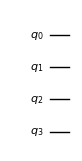

{'000': 2048}
constant


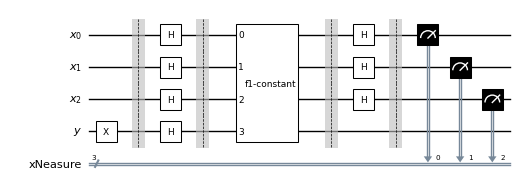

-----------------------------------------------------


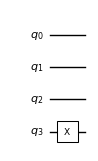

{'000': 2048}
constant


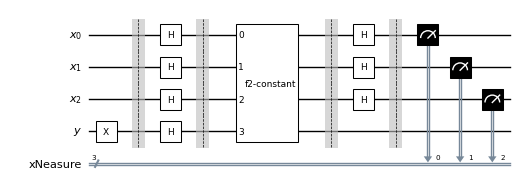

-----------------------------------------------------


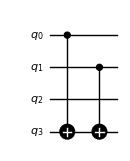

{'011': 2048}
balanced


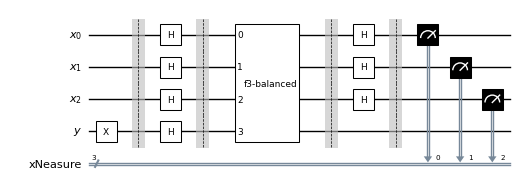

-----------------------------------------------------


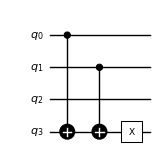

{'011': 2048}
balanced


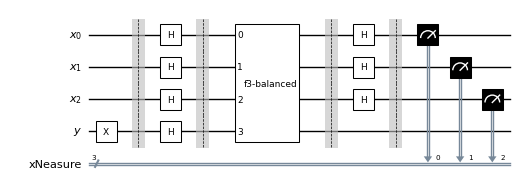

In [109]:
print_is_balanced_or_constant(f1(), 4)
print_is_balanced_or_constant(f2(), 4)
print_is_balanced_or_constant(f3(), 4)
print_is_balanced_or_constant(f4(), 4)

f1: 

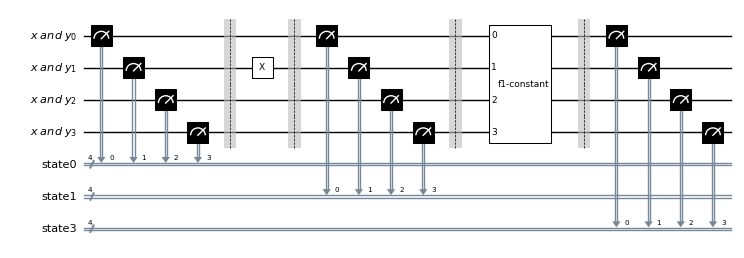

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0100'}
f2: 

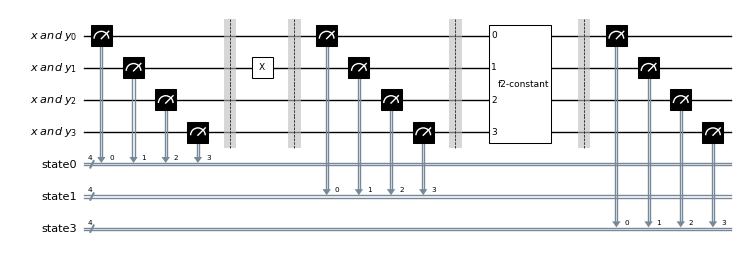

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0101'}
f3: 

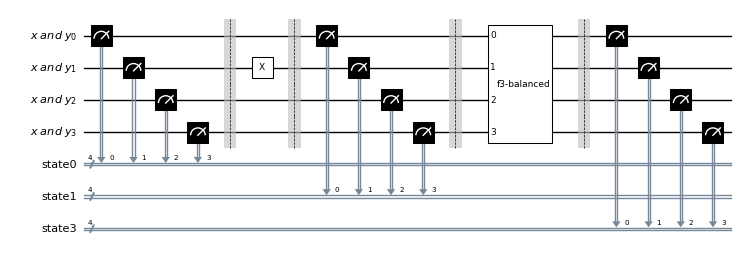

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0101'}
f4: 

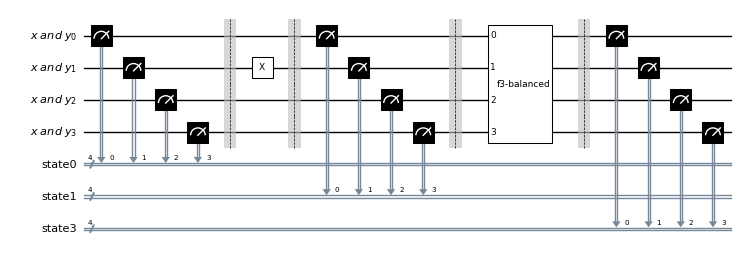

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0100'}


In [110]:
#bit 1 is the left most bit
bit1 = 0
bit2 = 1
bit3 = 0

print("f1: ", end="")
print(calc_answer(f1(), bit1, bit2, bit3, True))

print("f2: ", end="")
print(calc_answer(f2(), bit1, bit2, bit3, True))

print("f3: ", end="")
print(calc_answer(f3(), bit1, bit2, bit3, True))

print("f4: ", end="")
print(calc_answer(f4(), bit1, bit2, bit3, True))

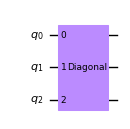

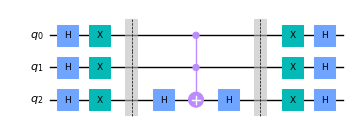

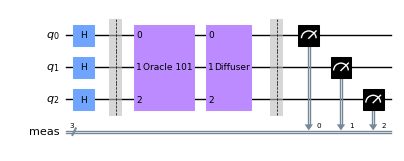

{'101': 73, '100': 7, '010': 5, '001': 1, '000': 6, '111': 3, '011': 3, '110': 2}


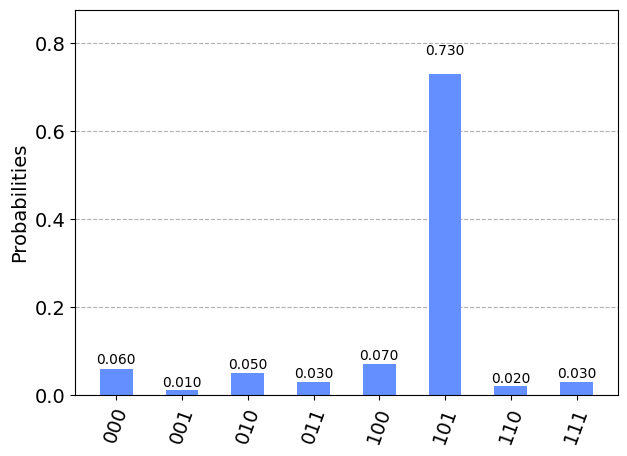

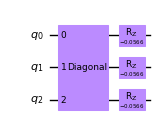

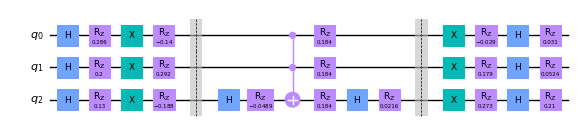

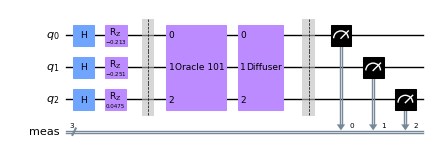

{'101': 76, '001': 5, '100': 4, '011': 5, '111': 7, '000': 2, '110': 1}


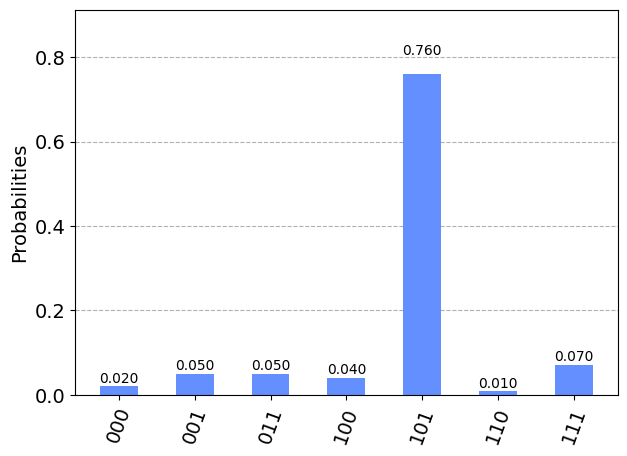

In [3]:

from qiskit.circuit.library import Diagonal
import random
from math import pi

error_level = 0 #pi * 0.1


def error(circuit, reg):
    global error_level
    if(error_level == 0):
        return
    err = (random.random()*2-1) * error_level
    circuit.rz(err, reg)


def oracle():
    oracle = Diagonal([1, 1, 1, 1, 1, -1, 1, 1])
    oracle.name = "Oracle 101"
    error(oracle, [0,1,2])
    return oracle


# created a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name="Diffuser")
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)

    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    error(qc, nqubits-1)

    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    error(qc, list(range(nqubits)))
    
    qc.h(nqubits-1)
    error(qc, nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)

    return qc


def grov():
    n = 3
    diffu = diffuser(n).to_instruction()
    diffu.name = 'Diffuser'

    orc = oracle().to_instruction()

    grover_circuit = QuantumCircuit(n, name="Grover")

    for i in range(n):
        grover_circuit.h(i)
        error(grover_circuit, i)

    grover_circuit.barrier()
    grover_circuit.append(orc, [0,1,2])
    grover_circuit.append(diffu, [0,1,2])

    grover_circuit.measure_all()

    return grover_circuit




def run_grover():
    total_counts = {}
    for i in range(100):
        grover_circuit = grov()

        job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1)
        counts_1 = job.result().get_counts(grover_circuit)

        for key in counts_1:
            if key in total_counts:
                total_counts[key] += counts_1[key]
            else:
                total_counts[key] = counts_1[key]


    print(total_counts)
    display(plot_histogram(total_counts))


error_level = 0
display(oracle().draw('mpl', scale=0.5))
display(diffuser(3).draw('mpl', scale=0.5))
display(grov().draw('mpl', scale=0.5))
run_grover()


error_level = 0.1 * pi
display(oracle().draw('mpl', scale=0.5))
display(diffuser(3).draw('mpl', scale=0.5))
display(grov().draw('mpl', scale=0.5))
run_grover()




## Q1.4

### Defining Pauli Matrices

$I=\begin{bmatrix}
  1.00 &  0.00\\
  0.00 &  1.00
\end{bmatrix}$
$X=\begin{bmatrix}
  0.00 &  1.00\\
  1.00 &  0.00
\end{bmatrix}$
$Z=\begin{bmatrix}
  1.00 &  0.00\\
  0.00 & -1.00
\end{bmatrix}$

### Defining Logical Pauli Operators

$\overline{I} = I \otimes I \otimes I \otimes I $

$\overline{X_1} = X_1 X_3 = X \otimes I \otimes X \otimes I $

$\overline{Z_1} = Z_1 X_4 = Z \otimes I \otimes I \otimes Z $

$\overline{X_2} = X_2 X_3 = I \otimes X \otimes X \otimes I $

$\overline{Z_2} = Z_2 Z_4 = I \otimes Z \otimes I \otimes Z $

$\overline{Z_1 \otimes X_2} = Z \otimes X \otimes X \otimes Z  $

$\overline{X_1 \otimes Z_2} = X \otimes Z \otimes X \otimes Z  $


<br/>

### Logical CNOT gates

$CNOT_{1,2} = 0.5( I + Z_1 + X_2 - Z_1 \otimes X_2) $
\
$=> \overline{CNOT_{1,2}} = 0.5( \overline{I} + \overline{Z_1} + \overline{X_2} - \overline{Z_1 \otimes X_2}) $
\
$= \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}$


<br/>


$CNOT_{2,1} = 0.5( I + Z_2 + X_1 - X_1 \otimes Z_2) $
\
$=> \overline{CNOT_{2,1}} = 0.5( \overline{I} + \overline{Z_2} + \overline{X_1} - \overline{X_1 \otimes Z_2}) $
\
$=\begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}$


### Define Logical Basis

$\ket{00}_L = \frac{1}{\sqrt{2}}(\ket{0000} + \ket{1111}) = \begin{bmatrix} 0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 \end{bmatrix}^T$

$\ket{01}_L = \frac{1}{\sqrt{2}}(\ket{0110} + \ket{1001}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

$\ket{10}_L = \frac{1}{\sqrt{2}}(\ket{1010} + \ket{0101}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

$\ket{11}_L = \frac{1}{\sqrt{2}}(\ket{1100} + \ket{0011}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

### Proof that CNOT1,2 is correct

$\overline{CNOT_{1,2}} \ket{00}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{00}_L
$





$\overline{CNOT_{1,2}} \ket{01}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{01}_L
$



$\overline{CNOT_{1,2}} \ket{10}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{11}_L
$



$\overline{CNOT_{1,2}} \ket{11}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{10}_L
$

### Proof that CNOT2,1 is correct

</br>

$\overline{CNOT_{2,1}} \ket{00}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{00}_L
$




$\overline{CNOT_{2,1}} \ket{01}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{11}_L
$



$\overline{CNOT_{2,1}} \ket{10}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{10}_L
$


$\overline{CNOT_{2,1}} \ket{11}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{01}_L
$


Q2

In [118]:
#Q2a
import numpy as np
from sklearn import datasets
import scipy as sp
from math import pi

print("Q2a")

iris = datasets.load_iris()

cov = np.cov(iris.data.T)

print("Covariance matrix is \n", cov)
print()

p = cov / np.trace(cov)

print("P is \n", p)
print()


e_i2piP = sp.linalg.expm( 1j * 2* pi * p )
print("e^i2piP is \n", e_i2piP)


(eig_values, eig_vectors) = np.linalg.eig(p)
print("eigen values is \n", eig_values)
print("eigen vectors is \n", eig_vectors)



Q2a
Covariance matrix is 
 [[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]

P is 
 [[ 0.14994532 -0.00927934  0.27866333  0.11289647]
 [-0.00927934  0.04154411 -0.07208823 -0.02659972]
 [ 0.27866333 -0.07208823  0.68145793  0.28331983]
 [ 0.11289647 -0.02659972  0.28331983  0.12705264]]

e^i2piP is 
 [[ 0.95987297+0.12111623j -0.02097918+0.13021024j -0.02747432-0.18818283j
  -0.00981929-0.10156707j]
 [-0.02097918+0.13021024j  0.96773497+0.21291705j  0.01459751+0.00150838j
   0.00461572+0.02288817j]
 [-0.02747432-0.18818283j  0.01459751+0.00150838j  0.91739894-0.31674232j
  -0.03455543-0.14309588j]
 [-0.00981929-0.10156707j  0.00461572+0.02288817j -0.03455543-0.14309588j
   0.98353158-0.00613646j]]
eigen values is 
 [0.92461872 0.05306648 0.01710261 0.00521218]
eigen vectors is 
 [[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [

Q2b


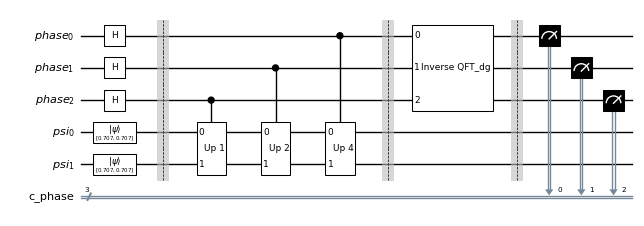

{'111': 1},
psi 1
fidelity:  0.9880812676468994


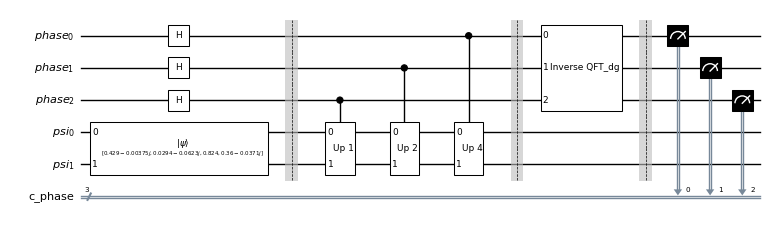

{'100': 1},{'110': 1},{'110': 1},{'100': 1},{'110': 1},{'111': 1},
psi 2
fidelity:  0.9996048263038522


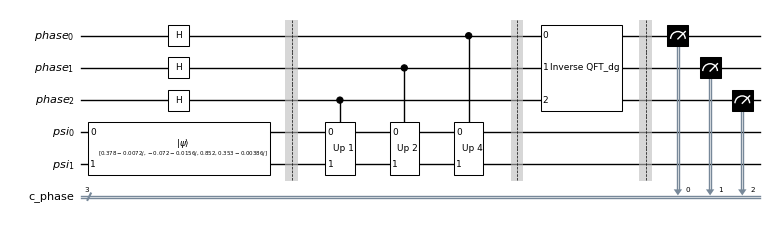

{'110': 1},{'100': 1},{'000': 1},{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'000': 1},{'000': 1},{'100': 1},{'000': 1},{'110': 1},{'000': 1},{'100': 1},{'100': 1},{'000': 1},{'000': 1},{'010': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'011': 1},{'011': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'100': 1},{'000': 1},{'110': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'000': 1},{'111': 1},
psi 3
fidelity:  0.9999867715051302


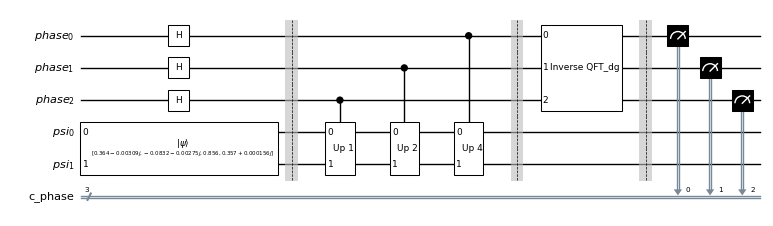

{'100': 1},{'010': 1},{'100': 1},{'110': 1},{'110': 1},{'110': 1},{'110': 1},{'100': 1},{'000': 1},{'100': 1},{'111': 1},
psi 4
fidelity:  0.9999995504076649
Principle Eigen Vector:
[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
Principle Eigen Vector phi 4:
[ 0.36159978-7.59764569e-04j -0.08435239-5.20256518e-04j
  0.85661762+0.00000000e+00j  0.35823969+9.86885851e-05j]
Principle Eigen Vector phi 4 absolute:
[0.36160058 0.08435399 0.85661762 0.3582397 ]


In [143]:
#Q2b
import numpy as np
from sklearn import datasets
import scipy as sp
from math import pi, sqrt

from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate

print("Q2b")


def qpe_c(psi_in, num_phase_bits=3):
    phase_quibts = QuantumRegister(num_phase_bits, "phase")
    psi = QuantumRegister(2, "psi")
    phase_bits = ClassicalRegister(num_phase_bits, "c_phase")

    qpe_circuit = QuantumCircuit(phase_quibts, psi, phase_bits, name="QPE")
    
    qpe_circuit.h(phase_quibts)
    if(len(psi_in)==2):
        qpe_circuit.initialize(psi_in[0], num_phase_bits)
        qpe_circuit.initialize(psi_in[1], num_phase_bits+1)
    else:
        qpe_circuit.initialize(psi_in, psi)
    

    qpe_circuit.barrier()

    for i in range(num_phase_bits):
        label = "Up " + str(2**i)
        u = UnitaryGate(sp.linalg.expm( 1j * 2* pi * 2**i * p), label=label).control(1)
        qpe_circuit.append(u, [num_phase_bits - i - 1 ,num_phase_bits,num_phase_bits+1])
  
    qpe_circuit.barrier()


    qpe_circuit.append(QFT(num_phase_bits, name="Inverse QFT").inverse(), phase_quibts)

    qpe_circuit.barrier()

    qpe_circuit.measure(phase_quibts, phase_bits)

    return qpe_circuit




def psi_out_111(qpe):
    while True:
        job = backend_sv.run(transpile(qpe, backend_sv), shots=1)
        result = job.result()
        counts = result.get_counts(qpe)
        print(counts, end=",")
        if('111' in counts):
            print()
            state = partial_trace(result.get_statevector(), [0,1,2]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
            return state.to_statevector().data


psi_0 = [[1/sqrt(2), 1/sqrt(2)], [1/sqrt(2), 1/sqrt(2)]]
    
def fidelity(a,b):
    print("fidelity: ", np.absolute(a.dot(b)))

principle_eigen_vector = eig_vectors.T[0]


qpe = qpe_c(psi_0)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_1 = psi_out_111(qpe)
print("psi 1")
fidelity(psi_1, principle_eigen_vector)


qpe = qpe_c(psi_1)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_2 = psi_out_111(qpe)
print("psi 2")
fidelity(psi_2, principle_eigen_vector)


qpe = qpe_c(psi_2)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_3 = psi_out_111(qpe)
print("psi 3")
fidelity(psi_3, principle_eigen_vector)

qpe = qpe_c(psi_3)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_4 = psi_out_111(qpe)
print("psi 4")
fidelity(psi_4, principle_eigen_vector)

print("Principle Eigen Vector:")
print(principle_eigen_vector)
print("Principle Eigen Vector phi 4:")
print(psi_4)

print("Principle Eigen Vector phi 4 absolute:")
print(np.absolute(psi_4))



Q2c
Example diagram for first principle eigen vector


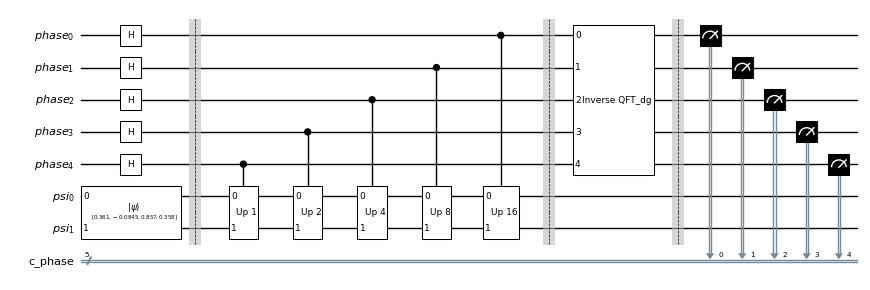

First Principle Eigen Vector 1: [ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
First Principle Eigen Value 1: 0.9246187232017269
b1,b2,b3,b4,b5:  00101
Measurement Outcome:  0.15625
Estimated Eigen Value:  0.078125

Second Principle Eigen Vector 2: [-0.65658877 -0.73016143  0.17337266  0.07548102]
Second Principle Eigen Value 2: 0.0530664831170677
b1,b2,b3,b4,b5:  00011
Measurement Outcome:  0.09375
Estimated Eigen Value:  0.046875


In [145]:
#Q2c
def psi_values_out(qpe):
    job = backend_sv.run(transpile(qpe, backend_sv), shots=2048)
    result = job.result()
    counts = result.get_counts(qpe)
    highest = -1
    highestCount = None
    for count in counts:    
        if(counts[count] > highest):
            highest = counts[count]
            highestCount = count

    measurement_outcome = 0
    highestCount = highestCount[::-1]
    for i in range(len(highestCount)):
        if(highestCount[i]=='1'):
            measurement_outcome += 1/(2**(i+1))

    print("b1,b2,b3,b4,b5: ", highestCount)
    print("Measurement Outcome: ", measurement_outcome)
    eigen_value_est = int(highestCount, 2)/2**(len(highestCount)+1)
    print("Estimated Eigen Value: ", eigen_value_est)

print("Q2c")



principle_eigen_vector1 = eig_vectors.T[0]
principle_eigen_vector2 = eig_vectors.T[1]


qpe = qpe_c(principle_eigen_vector1, 5)
print("Example diagram for first principle eigen vector")
display(qpe.draw('mpl',style="bw", scale = 0.5))
print("First Principle Eigen Vector 1:", principle_eigen_vector1)
print("First Principle Eigen Value 1:", eig_values[0])
psi_values_out(qpe)

qpe = qpe_c(principle_eigen_vector2, 5)
print()
print("Second Principle Eigen Vector 2:", principle_eigen_vector2)
print("Second Principle Eigen Value 2:", eig_values[1])
psi_values_out(qpe)



# Q3

### Q3.a

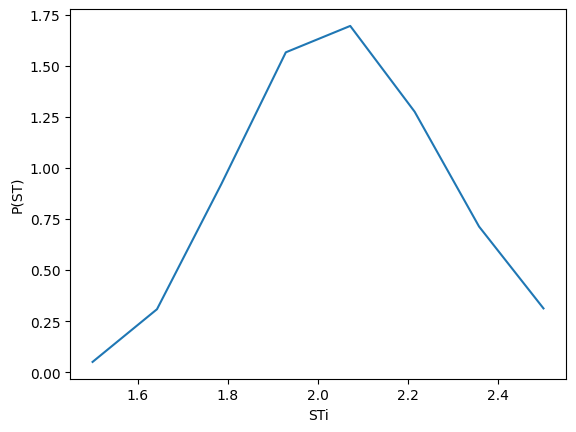

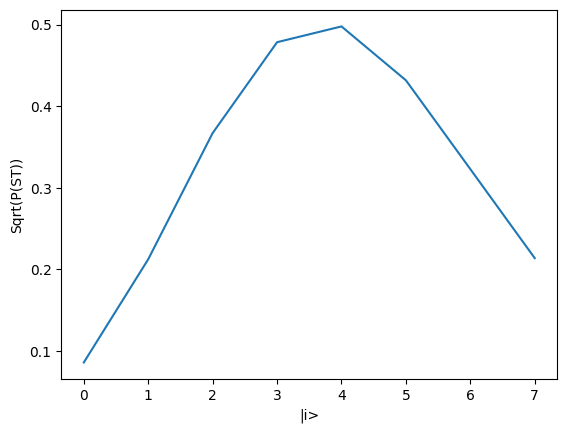

In [35]:
from math import sqrt, pi, exp, log as ln
import numpy as np
import matplotlib.pyplot as plt

def P(St):
    sig = 0.125
    T=300/365
    r=0.04
    S0=2

    sig2 = sig**2

    coef = 1/(St * sig * sqrt(2*pi*T)) 
    numerator = ln(St) - ln(S0) - T * (r - sig2/2)
    denomenator = 2 * sig2 * T

    exp_coef = -(numerator**2)/denomenator
    return coef * exp(exp_coef)



St_min = 1.5
St_max = 2.5
num_points = 8
step = (St_max - St_min)/(num_points-1)

P_Sti = []
Sti = []

sumP = 0
for i in range(0,8):
    x = i * step + St_min
    p = P(x)
    sumP += p
    P_Sti.append(p)
    Sti.append(x)

amp_P_Sti = []

for p in P_Sti:
    amp_P_Sti.append(sqrt(p/sumP))

plt.plot(Sti,P_Sti)
plt.ylabel('P(ST)')
plt.xlabel('STi')
plt.show()

plt.plot(np.arange(0, 8),amp_P_Sti)
plt.ylabel('Sqrt(P(ST))')
plt.xlabel('|i>')
plt.show()




### Q3.3

####Q3.3a



array([0, 1, 2, 3, 4, 5, 6, 7, 8])